In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

root_dir = '/content/gdrive/MyDrive/Data'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep
import math
from tensorflow.keras import layers

PseudoLabeling module

In [11]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics


def get_confusion_matrix(y_test, y_pred):
  confusion_matrix = np.zeros((number_of_columns, number_of_columns))

  for i in range(y_test1.shape[0]):
    class1 = y_test1[i]
    class2 = y_test2[i]

    if y_test[i] == 0:
      confusion_matrix[class2][class1] = confusion_matrix[class2][class1] + 1
    elif y_pred[i] == 0 and y_test[i] == 1:
      confusion_matrix[class2][class1] = confusion_matrix[class1][class2] + 1

  return confusion_matrix

def printConfusionMatrix(cf_matrix, Labels, show=True):
  #cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  
  print(cf_matrix)

  precisions = []
  recalls = []
  FPRs = []
  n = cf_matrix.shape[0]

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    sum_cols = cf_matrix[:, i].sum()

    total_vals += sum_vals
    tps += cf_matrix[i][i]
    recall = round(cf_matrix[i][i]/sum_vals, 2)
    recalls.append(recall)
    precision = round(cf_matrix[i][i]/sum_cols, 2)
    precisions.append(precision)
    f1_score = round(2 * precision * recall / (recall + precision), 2)

    # ROC
    TN = n - sum_vals - sum_cols + cf_matrix[i][i]
    FP = sum_cols - cf_matrix[i][i]
    FPR = round(FP / (FP + TN), 2)
    FPRs.append(FPR)
    if show:
      print("Precision, Recall and F1 Score for " + Labels[i] + " are " + str(precision) + ", " + str(recall) + ", " + str(f1_score))
      plt.plot([0,FPR, 1],[0,recall,1])

  accuracy = round(tps/total_vals, 2)

  cf_mat = np.zeros((cf_matrix.shape[0], cf_matrix.shape[0]))
  print(cf_mat.shape)
  for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[0]):
      cols_sum = cf_matrix[:,j].sum()
      cf_mat[i][j] = round(cf_matrix[i][j]/cols_sum, 2)

  if show:
    print("Accuracy is " + str(accuracy))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    #create ROC curve
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(Labels)
    plt.show()

    fig, siz = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', ax=siz)


    ax.set_title('Pseudo-labeling Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Pseudo-labeling Category')
    ax.set_ylabel('Actual Pseudo-labeling Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy

In [12]:
experience = 10

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
file_name = os.path.join(features_dir, "Labelled")

def encode_sleep_stage(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_state(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

dataset = pd.read_pickle(file_name)
dataset['Sleep State'] = dataset['Sleep State'].apply(lambda x: encode_sleep_stage(x))
dataset['Sleep State'] = pd.Series(np.array(dataset['Sleep State'])).interpolate()
dataset['Sleep State'] = np.array(dataset['Sleep State'].replace(to_replace = np.nan, value=4), dtype=np.int64)

Helper functions

In [22]:
from scipy.fft import fft

def perm(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = np.array(dataset.columns)
  randIdx = random.sample(range(0, len(columns)),len(columns))
  new_columns = []
  for i in range(len(columns)):
    new_columns.append(columns[randIdx[i]])
  dataset.columns = (new_columns)
  for i in range(len(columns)):
    column = new_columns[i]
    dataset[column] = orig_dataset[column]
  return dataset

def noise(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  stds = np.array(orig_dataset.std())
  #print(orig_dataset.std())
  #print(stds)
  columns = dataset.columns
  #print(len(columns))
  #print(len(stds))
  for i in range(len(columns)):
    std_val = stds[i] 
    column = columns[i]
    mean = dataset[column].mean()
    res = np.array(np.random.normal(mean, std_val, (orig_dataset.shape[0],)))
    dataset['std'] = res
    #print(str(mean)+','+str(std_val)+','+str(dataset['std'].head(2)))
    #print(res)
    dataset[column] = dataset[column] + dataset['std']
  dataset = dataset.drop(['std'], axis=1)
  #print(dataset.head(3))
  return dataset

def FFT(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = dataset.columns
  for i in range(len(columns)):
    column = columns[i]
    dataset[column] = fft(np.array(dataset[column]))
  return dataset

def scale(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = dataset.columns
  for column in columns:
    dataset.loc[:, column] *= 1.5
  return dataset

def negation(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = dataset.columns
  for column in columns:
    dataset.loc[:, column] *= -1
  return dataset

def negation_plus_noise(orig_dataset):
  negated_dataset = negation(orig_dataset)
  noised_dataset = noise(orig_dataset)
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = dataset.columns
  for column in columns:
    dataset[column] = negated_dataset[column] + noised_dataset[column]
  return dataset

def trad_test_split(dataset, test_train_ratio):
  dataset_size = dataset.shape[0]
  split_point = int(dataset_size * test_train_ratio)
  dataset_train = dataset[:split_point]
  dataset_test = dataset[split_point:]
  return dataset_train, dataset_test

def conv2_reshape(data):
  data = data.reshape(data.shape[0], data.shape[1], 1, 1)
  return data

def decompose_dataset(dataset, number_of_classes):
  datasets = []
  data_count = int(dataset.shape[0])
  for i in range(number_of_classes):
    dataset_portion = dataset[dataset['Sleep State']==i].reset_index(drop=True)
    datasets.append(dataset_portion)
  return datasets

def extract_anchors(datasets, number_of_classes, anchor_size):
  anchor_datasets = []
  for i in range(number_of_classes):
    anchor_dataset = datasets[i].sample(anchor_size).reset_index(drop=True)
    anchor_datasets.append(anchor_dataset)
  return anchor_datasets

def get_positive_negative_dataset(datasets, class_no, number_of_classes):
  positives_dataset = datasets[class_no]
  negatives_dataset = None

  for i in range(number_of_classes):
    if i != class_no:
      class_dataset = datasets[i]
      negatives_dataset = pd.concat([negatives_dataset, class_dataset])

  return positives_dataset, negatives_dataset

def build_pairs_per_anchor(positives_dataset, negatives_dataset, class_no, anchor, pairs_per_anchor):
  positives = positives_dataset.sample(n=pairs_per_anchor).reset_index(drop=True)
  positives = np.array(positives.drop(['Label', 'Sleep State'], axis=1))
  negatives = negatives_dataset.sample(n=pairs_per_anchor).reset_index(drop=True)
  negatives = np.array(negatives.drop(['Label', 'Sleep State'], axis=1))

  anchors = []
  for i in range(0, pairs_per_anchor):
    anchors.append(anchor)

  return positives, np.array(anchors), negatives

def build_pairs_per_class_no(datasets, class_no, anchors, pairs_per_anchor):
  number_of_classes = len(datasets)
  positives_dataset, negatives_dataset = get_positive_negative_dataset(datasets, class_no, number_of_classes)
  anchor_dataset = np.array(anchors[class_no].drop(['Label', 'Sleep State'], axis=1))
  positives, anchors, negatives = build_pairs_per_anchor(positives_dataset, negatives_dataset, class_no, anchor_dataset[0], pairs_per_anchor)

  for i in range(1, anchor_dataset.shape[0]):
    positives_new, anchors_new, negatives_new = build_pairs_per_anchor(positives_dataset, negatives_dataset, class_no, anchor_dataset[i], pairs_per_anchor)
    positives = np.append(positives, positives_new, axis=0)
    anchors = np.append(anchors, anchors_new, axis=0)
    negatives = np.append(negatives, negatives_new, axis=0)
    
  return positives, anchors, negatives

def build_pairs(datasets, anchor_datasets, pairs_per_anchor):
  number_of_classes = len(datasets)
  positives, anchors, negatives = build_pairs_per_class_no(datasets, 0, anchor_datasets, pairs_per_anchor)
  for class_no in range(1, number_of_classes):
    positives_new, anchors_new, negatives_new = build_pairs_per_class_no(datasets, class_no, anchor_datasets, pairs_per_anchor)
    positives = np.append(positives, positives_new, axis=0)
    anchors = np.append(anchors, anchors_new, axis=0)
    negatives = np.append(negatives, negatives_new, axis=0)
  return positives, anchors, negatives

def reform_dataset(dataset_test):
  labels_test = np.array(dataset_test['Sleep State'])
  dataset_test_array = np.array(dataset_test.drop(['Label', 'Sleep State'], axis=1))
  return dataset_test_array, labels_test

def construct_testing_pair(dataset_row, anchor_datasets):
  number_of_classes = len(anchor_datasets)
  positives = [dataset_row for i in range(number_of_classes)]
  anchors = []
  negatives = []

  class_range = [i for i in range(number_of_classes)]
  for i in range(0, number_of_classes):
    class_range.remove(i)
    negative_class = random.choice(class_range)
    class_range.append(i)

    anchor = anchor_datasets[i].sample(n=1)
    anchor = np.array(anchor.drop(['Label', 'Sleep State'], axis=1))
    anchors.append(anchor[0])

    negative = anchor_datasets[negative_class].sample(n=1)
    negative = np.array(negative.drop(['Label', 'Sleep State'], axis=1))
    negatives.append(negative[0])    
  return np.array(positives), np.array(anchors), np.array(negatives)
  
def construct_testing_pairs(dataset_test_array, anchor_datasets):
  positives, anchors, negatives = construct_testing_pair(dataset_test_array[0], anchor_datasets)

  for i in range(1, dataset_test_array.shape[0]):
    positives_new, anchors_new, negatives_new = construct_testing_pair(dataset_test_array[i], anchor_datasets)
    positives = np.append(positives, positives_new, axis=0)
    anchors = np.append(anchors, anchors_new, axis=0)
    negatives = np.append(negatives, negatives_new, axis=0)

  return positives, anchors, negatives

def predict_siamese(siamese, positives, anchors, number_of_classes):
  preds = siamese.predict([positives, anchors])
  final_pred = []
  for i in range(int(preds.shape[0]/number_of_classes)):
    final_pred.append(np.argmax(preds[i*number_of_classes:(i+1)*number_of_classes]))
  return final_pred

In [15]:
number_of_classes = 5
anchor_size = 1
pairs_per_anchor = 100
class_no = 0

#positives_dataset, negatives_dataset = get_positive_negative_dataset(datasets, class_no, number_of_classes)
#anchor_dataset = np.array(anchor_datasets[class_no].drop(['Label', 'Sleep State'], axis=1))
#db = datasets[0].drop(['Label', 'Sleep State'], axis=1).head(3)
#positives, anchors, negatives = build_pairs_per_class_no(datasets, class_no, anchor_datasets, pairs_per_anchor)

test_train_ratio = 0.9
dataset_train, dataset_test = trad_test_split(dataset.sample(frac = 1), test_train_ratio)

datasets = decompose_dataset(dataset_train, number_of_classes)
anchor_datasets = extract_anchors(datasets, number_of_classes, anchor_size)
positives, anchors, negatives = build_pairs(datasets, anchor_datasets, pairs_per_anchor)

print(len(anchor_datasets))

positives = conv2_reshape(positives)
anchors = conv2_reshape(anchors)
negatives = conv2_reshape(negatives)
labels = np.ones((positives.shape[0],))

#unchanged_positives = positives
#positives = np.append(positives, negatives, axis=0)
#negatives = np.append(negatives, unchanged_positives, axis=0)
#anchors = np.append(anchors, anchors, axis=0)

#sec_half_labels = [2 for i in range(labels.shape[0])]
#labels = np.append(labels, sec_half_labels, axis=0)

positives_train, positives_val = trad_test_split(positives, test_train_ratio)
anchors_train, anchors_val = trad_test_split(anchors, test_train_ratio)
negatives_train, negatives_val = trad_test_split(negatives, test_train_ratio)
labels_train, labels_val = trad_test_split(labels, test_train_ratio)

positives_train = np.append(positives_train, negatives_train, axis=0)
anchors_train = np.append(anchors_train, anchors_train, axis=0)
labels_train = np.append(labels_train, np.zeros((labels_train.shape[0],)))

positives_val = np.append(positives_val, negatives_val, axis=0)
anchors_val = np.append(anchors_val, anchors_val, axis=0)
labels_val = np.append(labels_val, np.zeros((labels_val.shape[0],)),axis=0)

print(positives.shape)
print(anchors.shape)
print(negatives.shape)
print(labels.shape)

5
(500, 700, 1, 1)
(500, 700, 1, 1)
(500, 700, 1, 1)
(500,)


In [14]:
dataset_cnn, cnn_lab = reform_dataset(dataset_train.sample(frac = 1))

dataset_cnn = conv2_reshape(dataset_cnn)

cnn_labels = []
for i in range(cnn_lab.shape[0]):
  label = np.zeros((number_of_classes,))
  label[cnn_lab[i]] = 1
  cnn_labels.append(label)
cnn_labels = np.array(cnn_labels)

print(dataset_cnn.shape)
print(cnn_labels.shape)

dataset_cnn_train, dataset_cnn_test = trad_test_split(dataset_cnn, test_train_ratio)
cnn_labels_train, cnn_labels_test = trad_test_split(cnn_labels, test_train_ratio)


(1080, 700, 1, 1)
(1080, 5)


Siamese Contrastive model

In [18]:
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )
    return contrastive_loss

def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

input = layers.Input((positives.shape[1], 1, 1))
#x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(70, (10, 1), strides=(10, 1), activation="tanh")(input)
#x = layers.MaxPool2D(pool_size=(5, 1), strides=(2, 1))(x)
x = layers.Conv2D(35, (10, 1), strides=(20, 1), activation="tanh")(x)
x = layers.Flatten()(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(128, activation="tanh")(x)
embedding_network = keras.Model(input, x)

input_1 = layers.Input((positives.shape[1],1,1))
input_2 = layers.Input((positives.shape[1],1,1))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
#normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(merge_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

output_layer_cnn = layers.Dense(5, activation="softmax")(tower_1)
cnn = keras.Model(inputs=[input_1], outputs=output_layer_cnn)

from tensorflow.keras.optimizers import RMSprop
rms = RMSprop(learning_rate=0.001)
cnn.compile(loss='categorical_crossentropy', optimizer=rms, metrics=["accuracy"])

siamese.compile(loss=loss(margin=1), optimizer='RMSprop', metrics=["accuracy"])
#siamese.summary()

#from keras.utils.vis_utils import plot_model
#plot_model(siamese, show_shapes=True, show_layer_names=True)


In [57]:
history_cnn = cnn.fit(
    dataset_cnn_train,
    cnn_labels_train,
    validation_data=(dataset_cnn_test, cnn_labels_test),
    batch_size=1,
    epochs=25,
)

Epoch 1/10
972/972 [==============================] - 4s 4ms/step - loss: 1.7284 - accuracy: 0.2984 - val_loss: 1.4763 - val_accuracy: 0.3796
Epoch 2/10
972/972 [==============================] - 4s 4ms/step - loss: 1.4104 - accuracy: 0.4722 - val_loss: 1.3032 - val_accuracy: 0.5093
Epoch 3/10
972/972 [==============================] - 4s 4ms/step - loss: 1.2879 - accuracy: 0.5123 - val_loss: 1.0928 - val_accuracy: 0.6204
Epoch 4/10
972/972 [==============================] - 4s 4ms/step - loss: 1.2020 - accuracy: 0.5617 - val_loss: 1.1524 - val_accuracy: 0.5833
Epoch 5/10
972/972 [==============================] - 4s 4ms/step - loss: 1.1253 - accuracy: 0.5628 - val_loss: 1.1058 - val_accuracy: 0.5370
Epoch 6/10
972/972 [==============================] - 4s 4ms/step - loss: 1.1007 - accuracy: 0.5689 - val_loss: 1.1470 - val_accuracy: 0.5093
Epoch 7/10
972/972 [==============================] - 4s 4ms/step - loss: 1.1070 - accuracy: 0.5813 - val_loss: 1.0428 - val_accuracy: 0.5926
Epoch 

In [20]:
history = siamese.fit(
    [positives_train, anchors_train],
    labels_train,
    validation_data=([positives_val, anchors_val], labels_val),
    batch_size=1,
    epochs=100,
)

Epoch 1/100
900/900 [==============================] - 4s 4ms/step - loss: 0.2266 - accuracy: 0.6556 - val_loss: 0.2470 - val_accuracy: 0.6100
Epoch 2/100
900/900 [==============================] - 3s 3ms/step - loss: 0.2257 - accuracy: 0.6522 - val_loss: 0.2676 - val_accuracy: 0.6400
Epoch 3/100
900/900 [==============================] - 3s 3ms/step - loss: 0.2188 - accuracy: 0.6822 - val_loss: 0.2579 - val_accuracy: 0.6800
Epoch 4/100
900/900 [==============================] - 3s 3ms/step - loss: 0.2198 - accuracy: 0.6522 - val_loss: 0.2522 - val_accuracy: 0.6500
Epoch 5/100
900/900 [==============================] - 3s 3ms/step - loss: 0.2192 - accuracy: 0.6500 - val_loss: 0.2301 - val_accuracy: 0.6800
Epoch 6/100
900/900 [==============================] - 3s 3ms/step - loss: 0.2150 - accuracy: 0.6767 - val_loss: 0.2550 - val_accuracy: 0.6900
Epoch 7/100
900/900 [==============================] - 3s 3ms/step - loss: 0.2145 - accuracy: 0.6756 - val_loss: 0.2150 - val_accuracy: 0.7300

KeyboardInterrupt: ignored

In [12]:
cont_model_file = os.path.join(features_dir, "ContModel.pkl")
siamese.save(cont_model_file)


(121,)
(605, 700, 1, 1)
(605, 700, 1, 1)
(605, 700, 1, 1)
19/19 [==============================] - 0s 12ms/step
[[ 1  3  1  3  3]
 [ 3 13  3  3  0]
 [ 0 12  6  0  0]
 [ 1  5  0 11  0]
 [10 11  8  6 18]]
Precision, Recall and F1 Score for N1 are 0.07, 0.09, 0.08
Precision, Recall and F1 Score for N2 are 0.3, 0.59, 0.4
Precision, Recall and F1 Score for N3 are 0.33, 0.33, 0.33
Precision, Recall and F1 Score for REM are 0.48, 0.65, 0.55
Precision, Recall and F1 Score for WAKE are 0.86, 0.34, 0.49
(5, 5)
Accuracy is 0.4


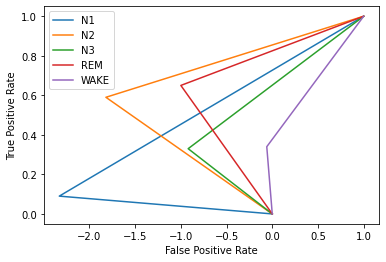

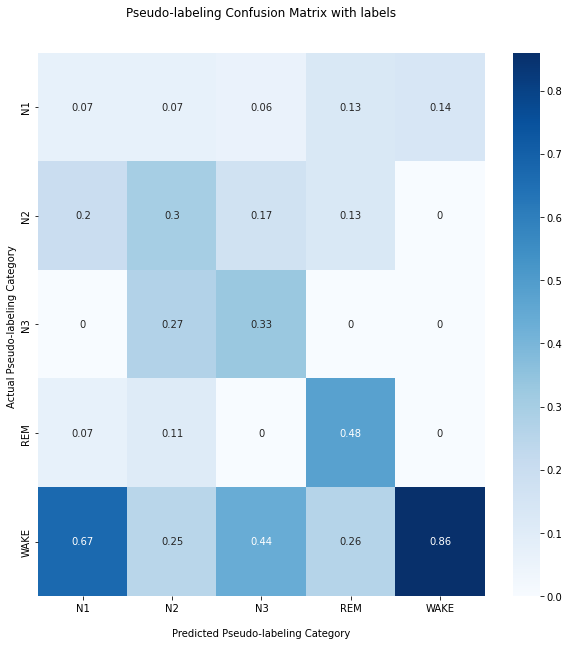

([0.07, 0.3, 0.33, 0.48, 0.86], 0.4)

In [21]:
arr = [i for i in range(5)]
random.choice(arr)

dataset_test_array, labels_test = reform_dataset(dataset_test)
positives, anchors, negatives = construct_testing_pairs(dataset_test_array, anchor_datasets)

positives = conv2_reshape(positives)
anchors = conv2_reshape(anchors)
negatives = conv2_reshape(negatives)

print(labels_test.shape)
print(positives.shape)
print(anchors.shape)
print(negatives.shape)

res = siamese.predict([positives, anchors])
#print(res[:10])
#print(labels_test[:10])

pred = predict_siamese(siamese, positives, anchors, number_of_classes)
cf_matrix = confusion_matrix(labels_test, pred)

Labels = ['N1', 'N2', 'N3', 'REM', 'WAKE']
printConfusionMatrix(cf_matrix, Labels, show=True)